# "Modal_Analysis"
### A Tool for *Modeling*, *Bracing* & *Modal Analysis*
### of *Rectangular 2D Frames* by *Finite Element Method*
##### 
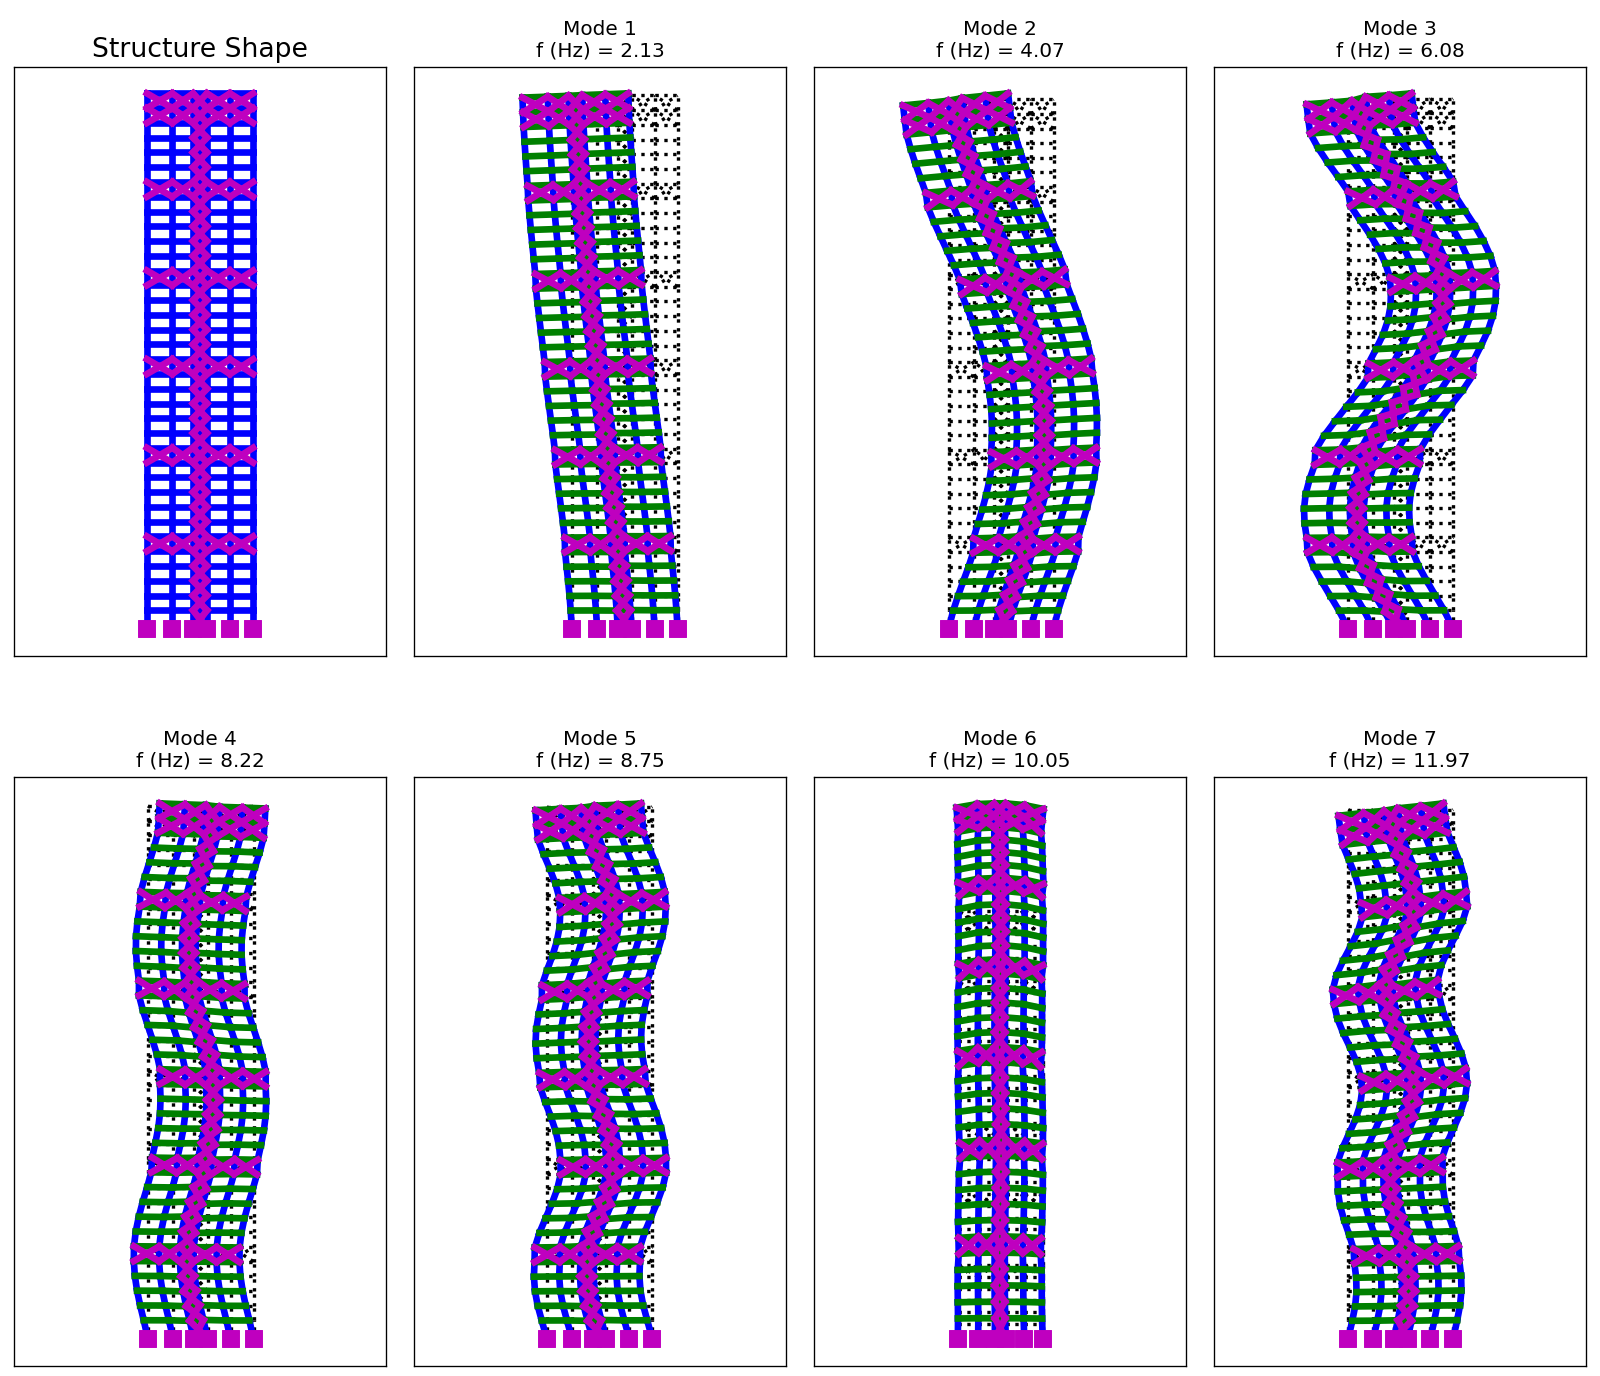
##### 

In [1]:
# (auto) importing modules needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy


##### 
### Structure Data (input)

In [2]:
# (input)
 
nStory      = 36                             # number of stories

hStory_typ  = 3200                           # height of typical stories
hStory_Base = 4000                           # height of base_floor                         

wBay = [5500, 4500, 3000, 5000, 5000 ]       # width of bays ( any amount )
   
Braced_Bays    = [ 3 ]                       # Doubly (X) Braced  Bays              
Braced_Stories = [ 6,12,18,24,30,35,36 ]     # Doubly (X) Braced Storys  

# sections:
# All Columns:    IPBv 220:  A=14900 (mm2)    I=146.0*10**6 (mm4) 
# All Beams:      IPE  300:  A= 5380 (mm2)    I= 83.6*10**6 (mm4) 
# All Diagonals:  UPE  120:  A= 1700 (mm2)   

E_Cols, E_Beams, E_Diags = 200,200,200       # Modulus of Elasticity (KN/mm2)
A_Cols, A_Beams, A_Diags = 14900,5380,1700   # Area (mm2)  
I_Cols, I_Beams          = 146e6,83.6e6      # Moment of Inertia (mm4)  

rho_Cols  = 7.85 / 10**12                    # Density: 
rho_Beams = 7.85 / 10**12                    #    Concrete:  2.4  / 10**12  KN-s2/mm / mm3
rho_Diags = 7.85 / 10**12                    #    Steel:     7.85 / 10**12  KN=s2/mm / mm3 

##### 
### Structure Data (auto)  

In [3]:
# (auto) Checking & completing

hStory    = np.ones( (nStory,1) ) * hStory_typ     
hStory[0] = hStory_Base

nBay = len(wBay)    # number of bays

Braced_Bays = sorted( Braced_Bays )
keep = []
for i in Braced_Bays:
    if i <= nBay: keep.append(i)
    else: print('\n Warning!',
                '\n Bay', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Bays' )
Braced_Bays = sorted(keep)  

Braced_Stories = sorted( Braced_Stories )
keep = []
for i in Braced_Stories:
    if i <= nStory: keep.append(i)
    else: print('\n Warning!',
                '\n Story', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Stories' )
Braced_Stories = sorted(keep) 

##### 
### Points & Connectivity Matrices

In [4]:
# (auto) Making Frame 

# defining a function called PC 
# to calculate Points & Connectivity matrices of Columns, beams and diagonals 

def PC( wBay, hStory, Braced_Bays, Braced_Stories ): 
    
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i
        Ywalk.append(h) 
    X=len(Xwalk)
    Y=len(Ywalk) 
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X):
            x.append( int(Xwalk[i]) )
            y.append( int(Ywalk[j]) )
            index.append(idx)
            idx = idx+1
    Dict = {  'x': x
            , 'y': y  }
    Points = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y-1): 
        for i in range(0,X): 
            x.append( int(i+j*X)   )
            y.append( int(i+j*X+X) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y }
    CnC = pd.DataFrame( data=Dict, index=index )
    
    x,y, index = [],[],[]
    idx=0
    for j in range(1,Y):
        for i in range(0,X-1): 
            p0 = i + j*X
            p1 = p0 + 1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y
           }
    CnB = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index = [],[],[]
    idx=0
    for b in Braced_Bays:
        for j in range(0,Y-1): 
            p0 = b-1 + j*X
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            p0 = b + j*X
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y }
    CnD_Bays = pd.DataFrame( data=Dict, index=index )

    x,y, index = [],[],[]
    idx=0
    for b in Braced_Stories:
        for i in range(0,X-1): 
            p0 = (b-1)*X + i
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            p0 = (b-1)*X + i+1
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y } 
    CnD_Stories = pd.DataFrame( data=Dict, index=index )    
    
    CnD = pd.concat([CnD_Bays,CnD_Stories],axis=0)
    CnD.index = range(0,len(CnD))
    
    # finding & removing duplicates in CnD
    Dup=[] 
    for i in range(0,len(CnD)):
        for j in range(i+1,len(CnD)):
            if CnD.iloc[i,0]==CnD.iloc[j,0]:
                if CnD.iloc[i,1]==CnD.iloc[j,1]:
                    Dup.append(j)
    CnD = CnD.drop(Dup)
    CnD.index = range(0,len(CnD)) 
    CnD = CnD.astype(int) 
    return [ Points, CnC, CnB, CnD ]

[ Points, CnC, CnB, CnD ] = PC( wBay, hStory, Braced_Bays, Braced_Stories ) 

##### 
### Plotting Structure Shape

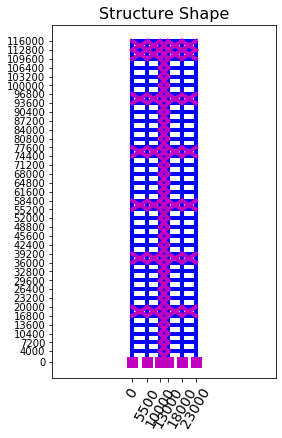

In [5]:
# define a function called Shape
# to check shape of frame

def  Shape( Points, CnC, CnB, CnD, wBay, hStory ):
    
    fig, ax = plt.subplots( figsize=(4,6.5) )
    
    for i in CnC.index: 
        i0 = CnC.loc[i,'from_point']
        i1 = CnC.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnD.index: 
        i0 = CnD.loc[i,'from_point']
        i1 = CnD.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='m', ls='-' )

    GroundPoints = Points[ Points.loc[:,'y']==0 ]  
    for i in GroundPoints.index:  
        x0 = GroundPoints.loc[i,'x']
        x1 = GroundPoints.loc[i,'x']
        y0 = GroundPoints.loc[i,'y']
        y1 = GroundPoints.loc[i,'y'] 
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=5, c='m', ls='-'
                , marker='s', markersize=10, mec='m', mew=1, mfc='m') 
        
    # title
    plt.title( 'Structure Shape', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    plt.xticks(rotation=60,fontsize=14)
    ax.set_xticks( xtks ) 
                  
    # yticks
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i 
        Ywalk.append(h)
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    
    ax.axis('equal')
    plt.savefig('Check_Shape.png', dpi=120) 
    plt.show()
        
Shape( Points, CnC, CnB, CnD, wBay, hStory )

#####   
### Finding Static Coefficients

In [6]:
# (auto) Coefficients
# define a function called Static_Coeff 
# to find Static Analysis Coefficients: 
#
#   NOP:    Number Of Points
#   NOD:    Number of "Degrees of freedom"
#   RD:     Restrained "Degrees of freedom"
#   FD:     Free "Degrees of freedom"
#   NFD:    Number of Free "Degrees of Freedom"
#   NC:     Number of Columns
#   NB:     Number of Beams
#   ND:     Number of Diagonals(braces)
#   IndxC:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all columns
#   IndxB:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all beams
#   IndxD:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all diagonals (braces)
 
def Static_Coeff( Points, CnC, CnB, CnD, wBay ):
    
    # NOP NOD RD FD NFD
    NOP=Points.shape[0]; NOD=NOP*3;
    X=len(wBay)+1; RD=sorted(list(range(0,3*X))); NRD=len(RD)
    FD=range(NRD,NOD); NFD=len(FD)
    
    # NX
    NC, NB, ND = CnC.shape[0],  CnB.shape[0],  CnD.shape[0]
    
    # IndxC
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NC ):
        c0.append( 3*CnC.iloc[i,0]+0 )
        c1.append( 3*CnC.iloc[i,0]+1 )
        c2.append( 3*CnC.iloc[i,0]+2 )
        c3.append( 3*CnC.iloc[i,1]+0 )
        c4.append( 3*CnC.iloc[i,1]+1 )
        c5.append( 3*CnC.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxC = pd.DataFrame( data=Dict, index=index )
    
    # IndxB
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NB ):
        c0.append( 3*CnB.iloc[i,0]+0 )
        c1.append( 3*CnB.iloc[i,0]+1 )
        c2.append( 3*CnB.iloc[i,0]+2 )
        c3.append( 3*CnB.iloc[i,1]+0 )
        c4.append( 3*CnB.iloc[i,1]+1 )
        c5.append( 3*CnB.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxB = pd.DataFrame( data=Dict, index=index )    
    
    # IndxD
    c0,c1,    c3,c4 = [],[],    [],[] 
    index, idx = [], 0  
    for i in range( 0, ND ):
        c0.append( 3*CnD.iloc[i,0]+0 )
        c1.append( 3*CnD.iloc[i,0]+1 ) 
        c3.append( 3*CnD.iloc[i,1]+0 )
        c4.append( 3*CnD.iloc[i,1]+1 ) 
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  
            , 'far_x' :c3  ,  'far_y' :c4  
        }
    IndxD = pd.DataFrame( data=Dict, index=index )
    
    return [NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD]


[NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD] = Static_Coeff( Points, CnC, CnB, CnD, wBay )


#####   
### Assigning

In [7]:
# (auto) define a function called Elements
# to asign material & shape Properties & distributed load 
# to columns, beams and trusses

def Elements(
      NB, IndxB, rho_Beams, E_Beams, A_Beams, I_Beams 
    , NC, IndxC, rho_Cols,  E_Cols,  A_Cols,  I_Cols  
    , ND, IndxD, rho_Diags, E_Diags, A_Diags  ):
    
    EC   = np.ones( [NC,1],'f4' ) * E_Cols
    rhoC = np.ones( [NC,1],'f4' ) * rho_Cols
    AC   = np.ones( [NC,1],'f4' ) * A_Cols
    IC   = np.ones( [NC,1],'f4' ) * I_Cols
    
    EB   = np.ones( [NB,1],'f4' ) * E_Beams
    rhoB = np.ones( [NB,1],'f4' ) * rho_Beams
    AB   = np.ones( [NB,1],'f4' ) * A_Beams
    IB   = np.ones( [NB,1],'f4' ) * I_Beams 
    
    ED   = np.ones( [ND,1],'f4' ) * E_Diags
    rhoD = np.ones( [ND,1],'f4' ) * rho_Diags
    AD   = np.ones( [ND,1],'f4' ) * A_Diags
    
    Beams     = IndxB[ ['far_x','far_y'] ].copy();   
    Columns   = IndxC[ ['far_x','far_y'] ].copy();   
    Diagonals = IndxD[ ['far_x','far_y'] ].copy();
    
    Beams['E']   = EB;      Columns['E']   = EC;      Diagonals['E']   = ED;
    Beams['rho'] = rhoB;    Columns['rho'] = rhoC;    Diagonals['rho'] = rhoD;
    Beams['A']   = AB;      Columns['A']   = AC;      Diagonals['A']   = AD;
    Beams['I']   = IB;      Columns['I']   = IC;   
    
    Beams = Beams.drop(['far_x','far_y'],axis=1)
    Columns = Columns.drop(['far_x','far_y'],axis=1)
    Diagonals = Diagonals.drop(['far_x','far_y'],axis=1)
     
    return [Beams, Columns, Diagonals]


# assigning properties & load to elements
[ Beams, Columns, Diagonals ] = Elements( NB, IndxB, rho_Beams, E_Beams, A_Beams, I_Beams  
                                        , NC, IndxC, rho_Cols,  E_Cols,  A_Cols,  I_Cols  
                                        , ND, IndxD, rho_Diags, E_Diags, A_Diags  )

#####   
### Elastic Stiffness Matrices 

In [8]:
# (auto) defining Stiffness Matrices

def ke_frame( A, E, I, L ):
    EI, EA, L2, L3 = E*I, E*A, L**2, L**3
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    c = {  'c1': [ EA/L   , 0        ,  0      , -1*EA/L,  0       ,  0       ]
         , 'c2': [ 0      , 12*EI/L3 ,  6*EI/L2,  0     , -12*EI/L3,  6*EI/L2 ]
         , 'c3': [ 0      , 6*EI/L2  ,  4*EI/L ,  0     , -6*EI/L2 ,  2*EI/L  ]
         , 'c4': [-1*EA/L , 0        ,  0      ,  EA/L  ,  0       ,  0       ]
         , 'c5': [ 0      , -12*EI/L3, -6*EI/L2,  0     ,  12*EI/L3, -6*EI/L2 ]  
         , 'c6': [ 0      , 6*EI/L2  , 2*EI/L  ,  0     , -6*EI/L2 ,  4*EI/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def ke_truss( A, E, L ):
    x = E*A/L
    r = [  'c1', 'c2', 'c3', 'c4'  ] 
    c = {  'c1': [  x  ,  0  , -x  ,  0  ]  
         , 'c2': [  0  ,  0  ,  0  ,  0  ]
         , 'c3': [ -x  ,  0  ,  x  ,  0  ]
         , 'c4': [  0  ,  0  ,  0  ,  0  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df 

def kg_frame( P, L ):
    x, L2 = P/L, L**2
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ]  
    c = {  'c1': [  P/L ,     0    ,      0      , -P/L ,     0    ,     0      ]
         , 'c2': [   0  ,  1.2*P/L ,     P/10    ,   0  , -1.2*P/L ,    P/10    ]
         , 'c3': [   0  ,    P/10  ,  2*(P*L)/15 ,   0  , -P/10    , -(P*L)/30  ]
         , 'c4': [ -P/L ,     0    ,      0      ,  P/L ,    0     ,     0      ]
         , 'c5': [   0  , -1.2*P/L ,    -P/10    ,   0  , 1.2*P/L  ,   -P/10    ]  
         , 'c6': [   0  ,    P/10  ,   -P*L/30   ,   0  ,  -P/10   , 2*(P*L)/15 ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def kg_truss( P, L ): 
    r = [  'c1', 'c2', 'c3', 'c4' ] 
    c = {  'c1': [  P/L  ,   0   , -P/L  ,  0    ]  
         , 'c2': [   0   ,  P/L  ,   0   , -P/L  ]
         , 'c3': [ -P/L  ,   0   ,  P/L  ,  0    ]
         , 'c4': [   0   , -P/L  ,   0   ,  P/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def T_frame( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6' ] 
    c = {  'c1': [  c  ,  s  ,   0  ,  0  ,  0  ,   0  ]  
         , 'c2': [ -s  ,  c  ,   0  ,  0  ,  0  ,   0  ]
         , 'c3': [  0  ,  0  ,   1  ,  0  ,  0  ,   0  ]
         , 'c4': [  0  ,  0  ,   0  ,  c  ,  s  ,   0  ]
         , 'c5': [  0  ,  0  ,   0  , -s  ,  c  ,   0  ]
         , 'c6': [  0  ,  0  ,   0  ,  0  ,  0  ,   1  ]
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T 

def T_truss( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4' ] 
    c = {  'c1': [  c  ,  s  ,  0  ,  0  ]  
         , 'c2': [ -s  ,  c  ,  0  ,  0  ]
         , 'c3': [  0  ,  0  ,  c  ,  s  ]
         , 'c4': [  0  ,  0  , -s  ,  c  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T



def m_frame( rho, A, L ):
    x = rho*A*L/420
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ]  
    c = {  'c1': [ 140*x ,    0    ,    0      ,  70*x ,    0    ,    0       ]
         , 'c2': [   0   , 156*x   , 22*x*L    ,   0   ,  54*x   , -13*x*L    ]
         , 'c3': [   0   ,  22*x*L ,  4*x*L**2 ,   0   ,  13*x*L ,  -3*x*L**2 ]
         , 'c4': [  70*x ,    0    ,    0      , 140*x ,    0    ,    0       ]
         , 'c5': [   0   ,  54*x   , 13*x*L    ,   0   , 156*x   , -22*x*L    ]  
         , 'c6': [   0   , -13*x*L , -3*x*L**2 ,   0   , -22*x*L ,   4*x*L**2 ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df 

def m_truss( rho, A, L ):
    x = rho*A*L/6
    r = [  'c1', 'c2', 'c3', 'c4'  ] 
    c = {  'c1': [ 2*x ,   0   ,  x  ,  0  ]  
         , 'c2': [  0  ,  2*x  ,  0  ,  x  ]
         , 'c3': [  x  ,   0   , 2*x ,  0  ]
         , 'c4': [  0  ,   x   ,  0  , 2*x ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df 

#####  
### Ke & M

In [9]:
# (auto) defining a function called KeM
# to form:
#    Elastic Stiffness Matrices, Ke, for all elements
#          Mass        Matrices, M,  for all elements 

def KeM(   Points,  NOD
         , CnB, NB, IndxB, Beams 
         , CnC, NC, IndxC, Columns
         , CnD, ND, IndxD, Diagonals ):
    
    # Empty Ke M
    KE = np.zeros([NOD,NOD],'float64')
    KE = pd.DataFrame( KE, columns = np.arange(0,NOD) )
    M  = np.zeros([NOD,NOD],'float64')
    M  = pd.DataFrame( M,  columns = np.arange(0,NOD) ) 
    
    # Assigning Properties  
    LC,  TC,  keC,  KeC, mC, MC  =  [],[],[],[],[],[]
    LB,  TB,  keB,  KeB, mB, MB  =  [],[],[],[],[],[]
    LD,  TD,  keD,  KeD, mD, MD  =  [],[],[],[],[],[]   
    
    for i in range(0,NC): 
        dx = Points.iloc[CnC.iloc[i,1],0]-Points.iloc[CnC.iloc[i,0],0]
        dy = Points.iloc[CnC.iloc[i,1],1]-Points.iloc[CnC.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LC.append(L)
        E  = Columns.loc[i,'E'];      
        rho= Columns.loc[i,'rho'];      
        A  = Columns.loc[i,'A'];         
        I  = Columns.loc[i,'I'];         
        c,s= dx/L, dy/L;    
        T  = T_frame(c,s);           TC.append(T)
        Indx = list(IndxC.iloc[i,:])
        ke = ke_frame(A,E,I,L);      keC.append(ke)   
        Ke = T.T @ ke @ T;           KeC.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values; 
        mx = m_frame(rho,A,L);       mC.append(mx)   
        Mx = T.T @ mx @ T;           MC.append(Mx)
        M.iloc[Indx,Indx] = M.iloc[Indx,Indx]+Mx.values; 
        
    for i in range(0,NB): 
        dx = Points.iloc[CnB.iloc[i,1],0]-Points.iloc[CnB.iloc[i,0],0]
        dy = Points.iloc[CnB.iloc[i,1],1]-Points.iloc[CnB.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LB.append(L)
        E  = Beams.loc[i,'E'];     
        rho= Beams.loc[i,'rho'];     
        A  = Beams.loc[i,'A'];         
        I  = Beams.loc[i,'I'];          
        c,s= dx/L, dy/L;
        T  = T_frame(c,s);           TB.append(T)
        Indx = list(IndxB.iloc[i,:])
        ke = ke_frame(A,E,I,L);      keB.append(ke)   
        Ke = T.T @ ke @ T;           KeB.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values;
        mx = m_frame(rho,A,L);       mC.append(mx)   
        Mx = T.T @ mx @ T;            MC.append(Mx)
        M.iloc[Indx,Indx] = M.iloc[Indx,Indx]+Mx.values;  
        
    for i in range(0,ND): 
        dx = Points.iloc[CnD.iloc[i,1],0]-Points.iloc[CnD.iloc[i,0],0]
        dy = Points.iloc[CnD.iloc[i,1],1]-Points.iloc[CnD.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LD.append(L)
        E  = Diagonals.loc[i,'E'];     
        rho= Diagonals.loc[i,'rho'];     
        A  = Diagonals.loc[i,'A'];         
        c,s= dx/L, dy/L;    
        T  = T_truss(c,s);           TD.append(T)
        Indx = list(IndxD.iloc[i,:])
        ke = ke_truss(A,E,L);        keD.append(ke)   
        Ke = T.T @ ke @ T;           KeD.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values;
        mx = m_truss(rho,A,L);       mC.append(mx)   
        Mx = T.T @ mx @ T;            MC.append(Mx)
        M.iloc[Indx,Indx] = M.iloc[Indx,Indx]+Mx.values; 
        
    Columns['L']   = LC
    Beams['L']     = LB
    Diagonals['L'] = LD
    Diagonals['L'] = round( Diagonals['L'],-1 )
    
    return [ KE,M, LC,TC,keC,KeC, LB,TB,keB,KeB, LD,TD,keD,KeD ] 


# Ke M 
[ KE,M, LC,TC,keC,KeC, LB,TB,keB,KeB, LD,TD,keD,KeD ] = KeM( 
        Points,  NOD
      , CnB, NB, IndxB, Beams 
      , CnC, NC, IndxC, Columns
      , CnD, ND, IndxD, Diagonals )

#####   
### Modal Analysis

In [10]:
# (auto) define a function called Modal
# to perform the modal analysis
#    Note:  f_Hz is list of frequencies
#    Note:  fi   is DataFrame of Mode-Shapes
#    Note:  header of fi = sorted( f_Hz )
#    Note:  numbr of considered modes = nStory

def Modal( KE, M, FD ):
    
    from scipy import linalg
    
    Kred = KE.iloc[FD,FD].copy()
    Mred = M.iloc[FD,FD].copy()
    
    w2, fi = linalg.eig(Kred,Mred)
    
    w    = np.abs(w2) ** .5 
    f_Hz = w / (2*np.pi)
    
    fi = pd.DataFrame( fi, columns = np.round(f_Hz,1).astype(float) )  
    fi = fi.sort_index(axis=1)            # Note:  Header of fi = sorted( f_Hz )
    fi = fi.iloc[:,range(0,nStory)]       # Note:  number of Modes = nStory
    
    f_Hz = sorted( f_Hz )
    f_dummy = []
    for i in range(0,nStory): f_dummy.append( round(f_Hz[i],2) )    
    f_Hz = f_dummy.copy()
 
    
    return [ f_Hz, fi ] 
 
    
[ f_Hz, fi ] = Modal( KE, M, FD )  

#####   
### Plotting a mode-shape
##### set the Scale manually

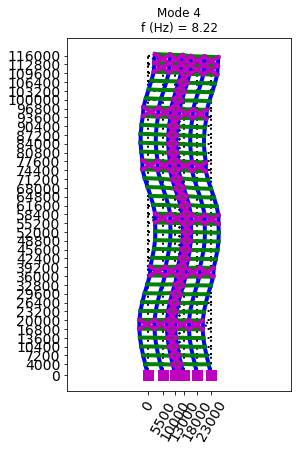

In [14]:
def Plot_Mode_Shape( Scale, Mode, Undeformed_YN, Points, NOD, nStory, fi, CnC,CnB,CnD, NC,NB,ND, wBay,hStory ):
     
    U = np.zeros([NOD,nStory],'float64')
    U = pd.DataFrame( U, columns = fi.columns )
    U.iloc[FD,:] = fi.iloc[:,:].values 
    
    Ux = U.iloc[ np.arange(0,NOD,3), : ]
    Uy = U.iloc[ np.arange(1,NOD,3), : ] 
    
    NewPoints = Points.copy()
    NewPoints.loc[:,'x'] = NewPoints.loc[:,'x']  +  Scale*Ux.iloc[:,Mode-1].values
    NewPoints.loc[:,'y'] = NewPoints.loc[:,'y']  +  Scale*Uy.iloc[:,Mode-1].values 
    
    fig, ax = plt.subplots( figsize=(4,6.5) )
    
    # Undeformed
    if ( Undeformed_YN in ['Y','y'] ):
           
        for i in CnC.index:                      
            i0 = CnC.loc[i,'from_point']
            i1 = CnC.loc[i,'to_point'  ]
            x0 = Points.loc[i0,'x']
            x1 = Points.loc[i1,'x']
            y0 = Points.loc[i0,'y']
            y1 = Points.loc[i1,'y']
            x = [x0,x1]
            y = [y0,y1]
            ax.plot( x, y, lw=2, c='k', ls=':' )
        
        for i in CnB.index: 
            i0 = CnB.loc[i,'from_point']
            i1 = CnB.loc[i,'to_point'  ]
            x0 = Points.loc[i0,'x']
            x1 = Points.loc[i1,'x']
            y0 = Points.loc[i0,'y']
            y1 = Points.loc[i1,'y']
            x = [x0,x1]
            y = [y0,y1]
            ax.plot( x, y, lw=2, c='k', ls=':' )
        
        for i in CnD.index: 
            i0 = CnD.loc[i,'from_point']
            i1 = CnD.loc[i,'to_point'  ]
            x0 = Points.loc[i0,'x']
            x1 = Points.loc[i1,'x']
            y0 = Points.loc[i0,'y']
            y1 = Points.loc[i1,'y']
            x = [x0,x1]
            y = [y0,y1]
            ax.plot( x, y, lw=2, c='k', ls=':' )

    # deformed
    for i in CnC.index:
        i0 = CnC.loc[i,'from_point']            
        i1 = CnC.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='b', ls='-' )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='g', ls='-' )
        
    for i in CnD.index: 
        i0 = CnD.loc[i,'from_point']
        i1 = CnD.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='m', ls='-' )
    
    # Ground Points
    GroundPoints = Points[ Points.loc[:,'y']==0 ]  
    for i in GroundPoints.index:  
        x0 = GroundPoints.loc[i,'x']
        x1 = GroundPoints.loc[i,'x']
        y0 = GroundPoints.loc[i,'y']
        y1 = GroundPoints.loc[i,'y'] 
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=5, c='m', ls='-'
                , marker='s', markersize=10, mec='m', mew=1, mfc='m')    
    
    # xticks
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    plt.xticks(rotation=60,fontsize=14)
    ax.set_xticks( xtks ) 
                  
    # yticks
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i 
        Ywalk.append(h)
    ytks = np.array(Ywalk,dtype='f8')
    plt.yticks(rotation=0,fontsize=14)
    ax.set_yticks( ytks )
    
    # title
    ax.set_title('Mode '+str(Mode)+'\nf (Hz) = '+str(f_Hz[Mode]))
    
    ax.axis('equal')
    plt.savefig('Mode_'+str(Mode)+'.png', dpi=120) 
    plt.show() 
 
    return None



# (input) Mode-Shape
Scale = 30000
Mode  = 4
Undeformed_YN = 'Y'    

Plot_Mode_Shape( Scale, Mode, Undeformed_YN, Points, NOD, nStory, fi, CnC,CnB,CnD, NC,NB,ND, wBay,hStory )

##### 
### Important DataFrames

In [12]:
#f_Hz    # frequencies
#fi      # Mode-Shapes   Note:  header of fi  is  f_Hz

#####  
### Important Visualizers

In [13]:
#Shape( Points, CnC, CnB, CnD, wBay, hStory )     # Structure Shape

#Scale=100000; Mode=2; Undeformed_YN='Y';          # Mode-Shapes
#Plot_Mode_Shape(Scale,Mode,Undeformed_YN,Points,NOD,nStory,fi,CnC,CnB,CnD,NC,NB,ND,wBay,hStory)

##### 